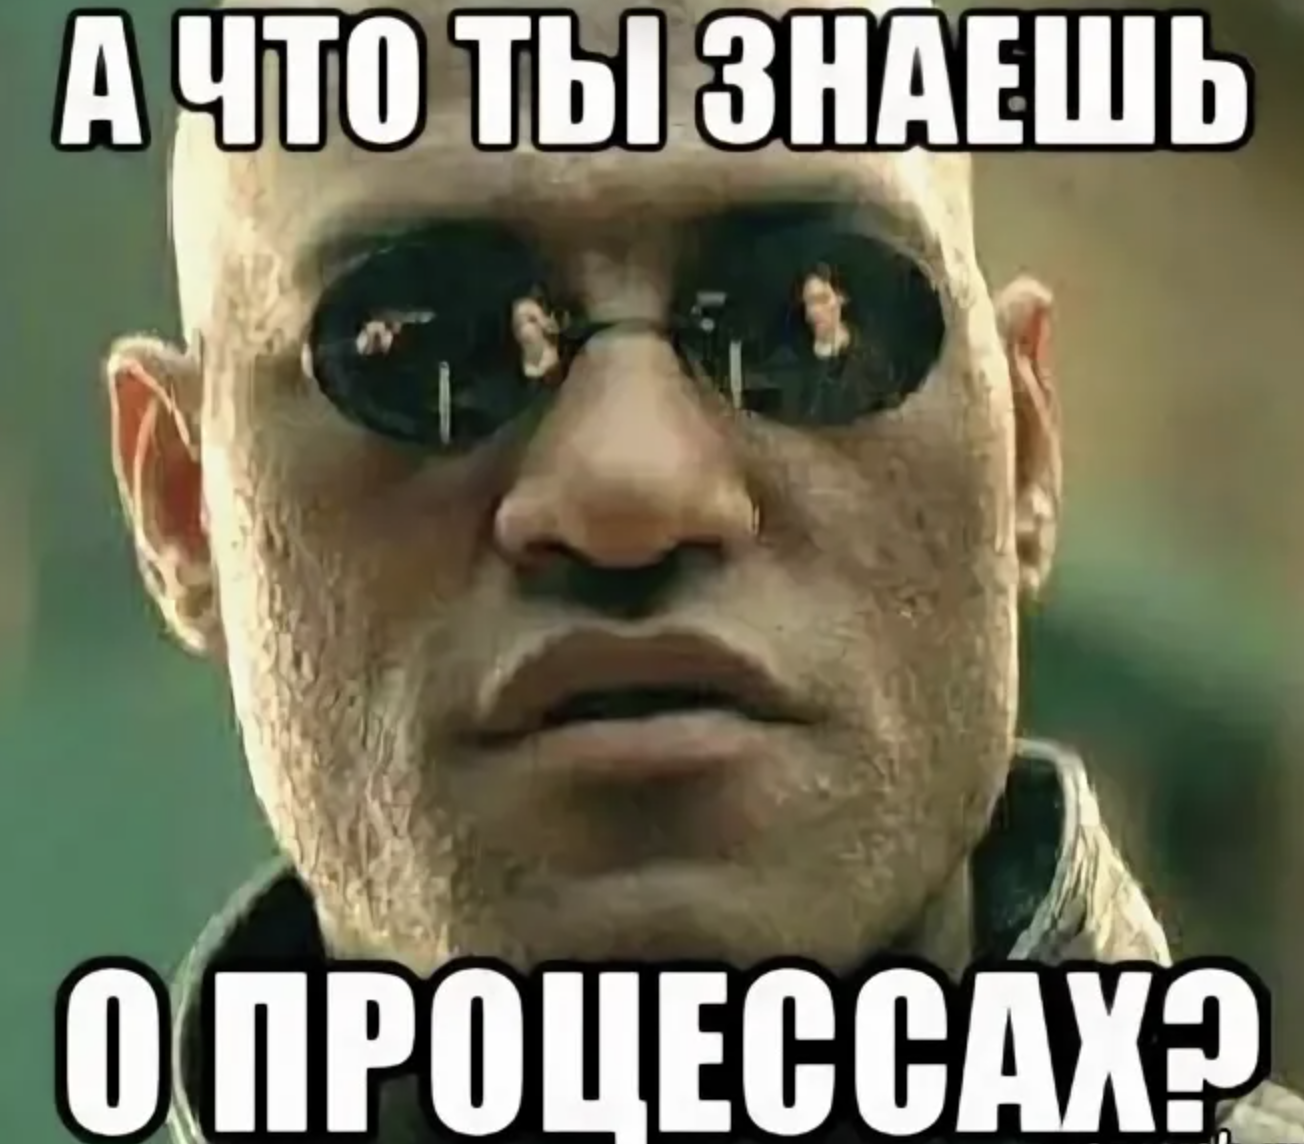

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn')

<ipython-input-1-8924ee9f65f2>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Задание 1.
 Создать модель для симуляции 3 скоррелированных между собой риск-факторов:
  - Мгновенная процентная ставка для валюты Рубль
  - Мгновенная процентная ставка для валюты Доллар США
  - Обменный курс Рубль-Доллар

Для симуляции процентных ставок использовать модель Кокса-Ингерсолла-Росса (CIR)
  - $dX_t=a(b-X_t)dt + \sigma\sqrt{X_t} dW_t$
  - $2ab \geqslant c^2$

Для симуляции обменного курса использовать логарифмическую модель с лекции от 26.11.2022

Симуляции провести для расчетной даты 10.12.2021

Выбор шага симуляции и количества симуляций обосновать (используя 2 задачу проекта)

## Моделирование процентной ставки

In [ ]:
import pandas as pd
import numpy as np

# Load LIBOR data
libor = (
    pd.read_csv('libor.csv')[['date', ' value']]
    .rename(columns={' value': 'ffr'})
)
libor['date'] = pd.to_datetime(libor['date'])
libor.set_index('date', drop=True, inplace=True)

# Resample and forward-fill missing values in LIBOR data
idx_libor = pd.date_range('2015-01-01', '2022-12-20')
libor = libor.reindex(idx_libor)[['ffr']]
libor['ffr'] = libor['ffr'].fillna(method='ffill')

# Load Moscow Prime Rate data
mos_prime = (
    pd.read_csv('mos_prime.csv', encoding='cp1251', sep=';')[['Date', 'ON']]
    .rename(columns={'Date': 'date', 'ON': 'mp_rate'})
)
mos_prime['mp_rate'] = (
    mos_prime['mp_rate']
    .str.replace(',', '.')
    .replace(['--', '–', '-'], np.nan)
    .astype(np.float64)
)
mos_prime['date'] = pd.to_datetime(mos_prime['date'], format='%d.%m.%Y')
mos_prime.set_index('date', drop=True, inplace=True)

# Resample and forward-fill missing values in Moscow Prime Rate data
idx_mos_prime = pd.date_range('2015-01-12', '2022-12-20')
mos_prime = mos_prime.reindex(idx_mos_prime)[['mp_rate']]
mos_prime['mp_rate'] = mos_prime['mp_rate'].fillna(method='ffill')

# Load USD to RUB exchange rate data
fx = (
    pd.read_csv('usd_rub.csv', sep=';')
    .rename(columns={'fx': 'fx', 'date': 'date'})
)
fx['fx'] = fx['fx'].str.replace(',', '.').astype(np.float64)
fx['date'] = pd.to_datetime(fx['date'], format='%d.%m.%Y')

# Resample and forward-fill missing values in exchange rate data
idx_fx = pd.date_range('2015-01-01', '2022-12-20')
fx.index = pd.DatetimeIndex(fx['date'])
fx = fx.reindex(idx_fx)[['fx']]
fx['fx'] = fx['fx'].fillna(method='ffill')

# Concatenate all rates into a single DataFrame
all_rates = pd.concat([libor, mos_prime, fx], axis=1)
all_rates = all_rates.rename(columns={'mp_rate': 'rub', 'ffr': 'usd'})

# Calculate values for the specified date (10.12.2021)
values_10_12_2021 = all_rates.loc['2021-12-10'].to_dict()
values_10_12_2021

{'usd': 0.16, 'rub': 7.69, 'fx': 73.5998}

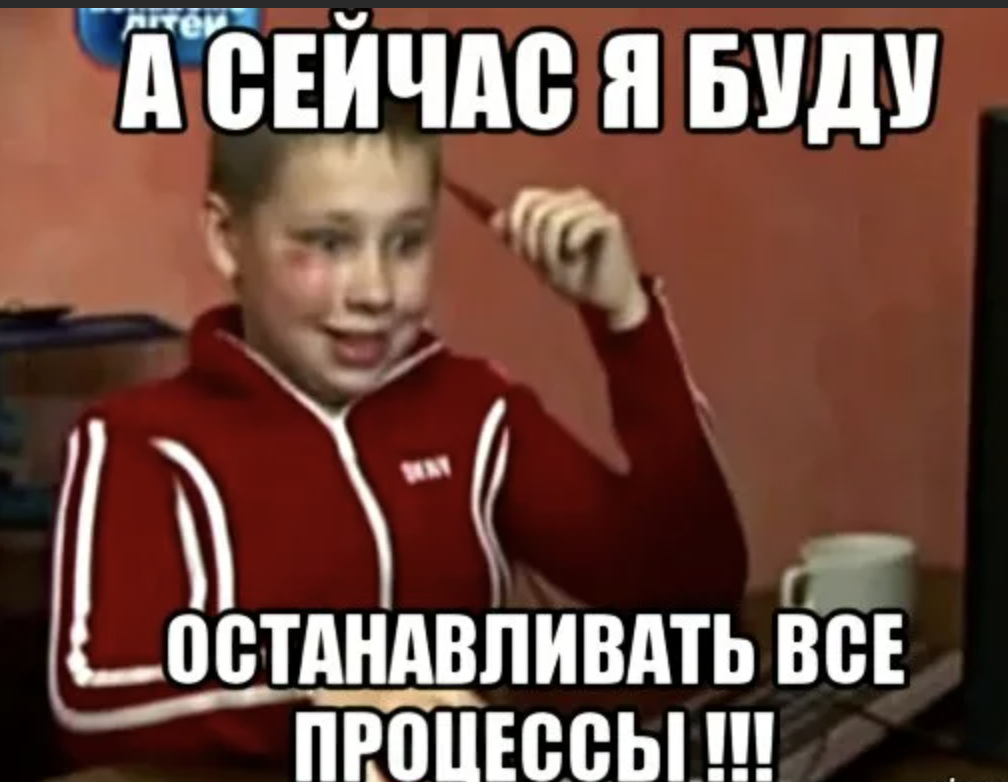

## Модель процентной ставки:

  - $dX_t=a(b-X_t)dt + \sigma\sqrt{X_t} dW_t$
  - $2ab \geqslant c^2$

Дискретизация модели:
  $$
X_{t_{i+1}} - X_{t_i} = a(b-X_{t_i}) \Delta t + \sigma \sqrt{|X_{t_i}|} \sqrt{\Delta t} Z_i,
  $$

где $Z_i \sim_{iid} \mathcal{N}(0,1)$. Абсолютное значение $X$ берется с учетом возможных ошибок дискретизации (симуляцию может завести не туда, хоть CIR процесс и положительный).

Оценивать параметры для динамики процентных ставок будем при помощи МНК.

$$
\begin{aligned}
 & \frac{X_{t_{i+1}} - X_{t_i}}{\sqrt{|X_{t_i}|}} = ab\frac{\Delta t}{\sqrt{|X_{t_i}|}} - a\sqrt{|X_{t_i}|} \Delta t + \sigma\sqrt{\Delta t} Z_i \\
& y_i = \frac{X_{t_{i+1}} - X_{t_i}}{\sqrt{|X_{t_i}|}} \\
& \beta_1 = ab \\
& \beta_2 = -a \\
& x_{1i} = \frac{\Delta t}{\sqrt{|X_{t_i}|}} \\
& x_{2i} = \sqrt{|X_{t_i}|} \Delta t \\
& \varepsilon_i = \sigma\sqrt{\Delta t} Z_i
\end{aligned}
$$

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def cir_params(s: pd.Series):
    '''
    Оценка параметров модели CIR
    '''
    delta_t = 1
    reg_data = pd.DataFrame(s)
    reg_data['delta_X'] = s.diff().shift(-1)
    reg_data['x_1'] = delta_t / np.sqrt(np.abs(s))
    reg_data['x_2'] = np.sqrt(np.abs(s)) * delta_t
    reg_data['y'] = reg_data['delta_X'] / np.sqrt(np.abs(s))
    reg_data.dropna(inplace=True)

    y = reg_data['y']
    X = reg_data[['x_1', 'x_2']]
    model = sm.OLS(y, X)
    results = model.fit()
    beta_1, beta_2 = results.params

    std_epsilon = results.resid.std()

    sigma = std_epsilon / np.sqrt(delta_t)
    a = -beta_2
    b = beta_1 / a

    return a, b, sigma

a_rub, b_rub, sigma_rub = cir_params(mos_prime['mp_rate'])
a_usd, b_usd, sigma_usd = cir_params(libor['ffr'])

def plot_results(sim, title, ylim=None, upper_bound=None, lower_bound=None):
    '''
    Помогает рисовать графики
    '''
    fig, ax = plt.subplots(1, figsize=(12, 8))
    for row in sim:
        ax.plot(row, alpha=0.3, color='blue', lw=.5)
    ax.plot(sim.mean(axis=0), label='Среднее', color='green', lw=5)
    ax.set(title=title, xlabel='Дни', ylabel='Значения')
    ax.legend()

    if ylim is not None:
        plt.ylim(ylim)
    plt.xlim(0)
    if upper_bound is not None:
        plt.axhline(y=upper_bound, color='r', linestyle='-')
    if lower_bound is not None:
        plt.axhline(y=lower_bound, color='r', linestyle='-')
    plt.show()

def generate_CIR_process(N, X_0, a, b, sigma, sample_size, dW=None, plot=False):
    '''
    Генерация N симуляций CIR
    '''
    if dW is None:
        dW = sigma * np.random.normal(size=(sample_size, N))
    else:
        dW = sigma * dW

    CIR = np.zeros((sample_size, N))
    CIR[:, 0] = X_0
    for i in range(1, CIR.shape[1]):
        X_prev = CIR[:, i - 1]
        mean_convergence_component = a * (b - X_prev)
        stochastic_component = dW[:, i] * np.sqrt(np.abs(X_prev))

        CIR[:, i] += X_prev + mean_convergence_component + stochastic_component
    if plot:
        plot_results(CIR, title='Симуляции ставки')
    return CIR

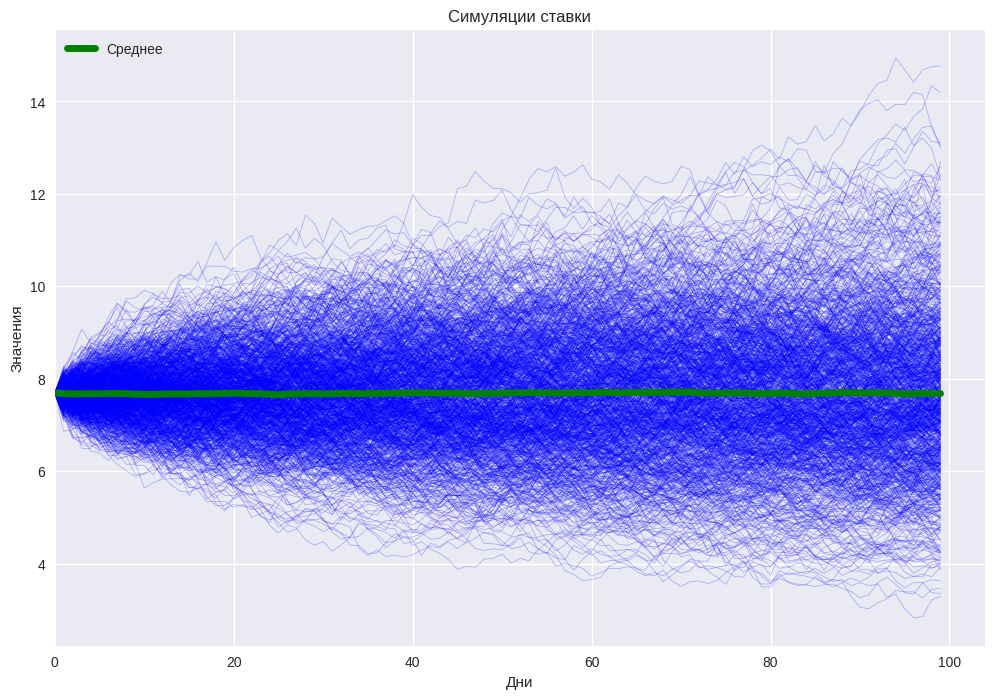

In [ ]:
R_rub = generate_CIR_process(100, values_10_12_2021['rub'], a_rub, b_rub, sigma_rub, 1000, plot=True)

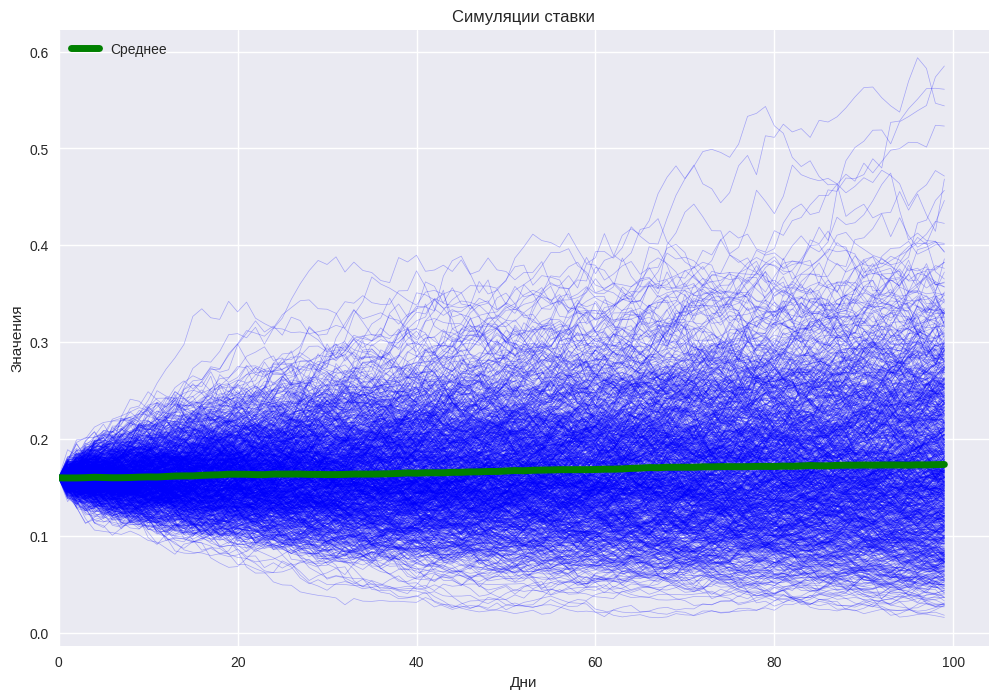

In [ ]:
R_usd = generate_CIR_process(100, values_10_12_2021['usd'], a_usd, b_usd, sigma_usd, 1000, plot=True)

Теперь обеспечим скоррелированность стохастических компонент наших процессов. Эти компоненты потом будем подавать в генераторы CIR и модели обменного курса.

In [ ]:
def generate_correlated_dW(N, sample_size, corr_matrix):

  cholesky = np.linalg.cholesky(corr_matrix)
  non_correlated_dw = np.array([np.random.normal(size=(sample_size, N)) for _ in range(3)])
  non_correlated_dw = np.transpose(non_correlated_dw, (1,0,2))
  correlated_dw = np.dot(cholesky, non_correlated_dw)

  return correlated_dw

# Модель обменного курса

Ставки генерировать умеем, осталось реализовать модель обменного курса.

$$
\frac{dX_t}{X_t} = [r_f (t) - r_d (t) + \lambda]dt + \sigma dW_t
$$

$$
X_{t_{i+1}} - X_{t_i} = X_{t_i}[r_f (t_i) - r_d (t_i) + \lambda]\Delta t + \sigma X_{t_i} \sqrt{\Delta t}Z_i
$$

С помощью МНК нужно оценить два параметра &mdash; $\lambda$ и $\sigma$.
$$
\frac{X_{t_{i+1}} - X_{t_i}}{X_{t_i}} - [r_f (t_i) - r_d (t_i)]\Delta t = \lambda \Delta t + \sigma\sqrt{\Delta t}Z_i,
$$
где $\beta = \lambda \Delta t$ и $\varepsilon_i = \sigma\sqrt{\Delta t}Z_i$.

In [ ]:
corr_matrix = all_rates.diff().dropna().corr()
corr_matrix

usd       rub        fx
usd  1.000000 -0.001375  0.008591
rub -0.001375  1.000000 -0.006786
fx   0.008591 -0.006786  1.000000

In [ ]:
from sklearn.linear_model import LinearRegression

def estimate_fx_params(df: pd.DataFrame):
    '''
    Функция для оценки параметров модели обменного курса.
    '''
    delta_t = 1
    reg_data = df.copy()
    reg_data['delta_X'] = df['fx'].diff().shift(-1)
    reg_data['y'] = (reg_data['delta_X'] / reg_data['fx']) - (reg_data['usd'] / 100 - reg_data['rub'] / 100) * delta_t
    reg_data['x_1'] = np.ones(len(reg_data))
    reg_data.dropna(inplace=True)

    linreg = LinearRegression(fit_intercept=False).fit(reg_data[['x_1']], reg_data['y'])
    beta = linreg.coef_[0]
    std_epsilon = np.sqrt(np.square(reg_data['y'] - linreg.predict(reg_data[['x_1']])).sum()) / np.sqrt(reg_data.shape[0])

    sigma = std_epsilon / np.sqrt(delta_t)
    lambda_ = beta / delta_t

    return lambda_, sigma

In [ ]:
lambda_fx, sigma_fx = estimate_fx_params(all_rates)

In [ ]:
lambda_fx

0.0783161753659154

In [ ]:
sigma_fx

0.035247506564620994

In [ ]:
def generate_FX_process(X_0, lambda_, sigma, foreign, domestic, dW, plot=False):
  dW = sigma * dW
  FX = np.zeros(foreign.shape)
  FX[:, 0] = X_0
  for i in range(FX.shape[1]-1):
    X_prev = FX[:, i]
    foreign_prev = foreign[:, i]
    domestic_prev = domestic[:, i]
    rate_component = X_prev * (foreign_prev/100 - domestic_prev/100 + lambda_)
    stochastic_component = X_prev * dW[:, i+1]

    FX[:, i+1] += X_prev + rate_component + stochastic_component


  if plot:
    plot_results(FX, title='Симуляции обменного курса')
  return FX

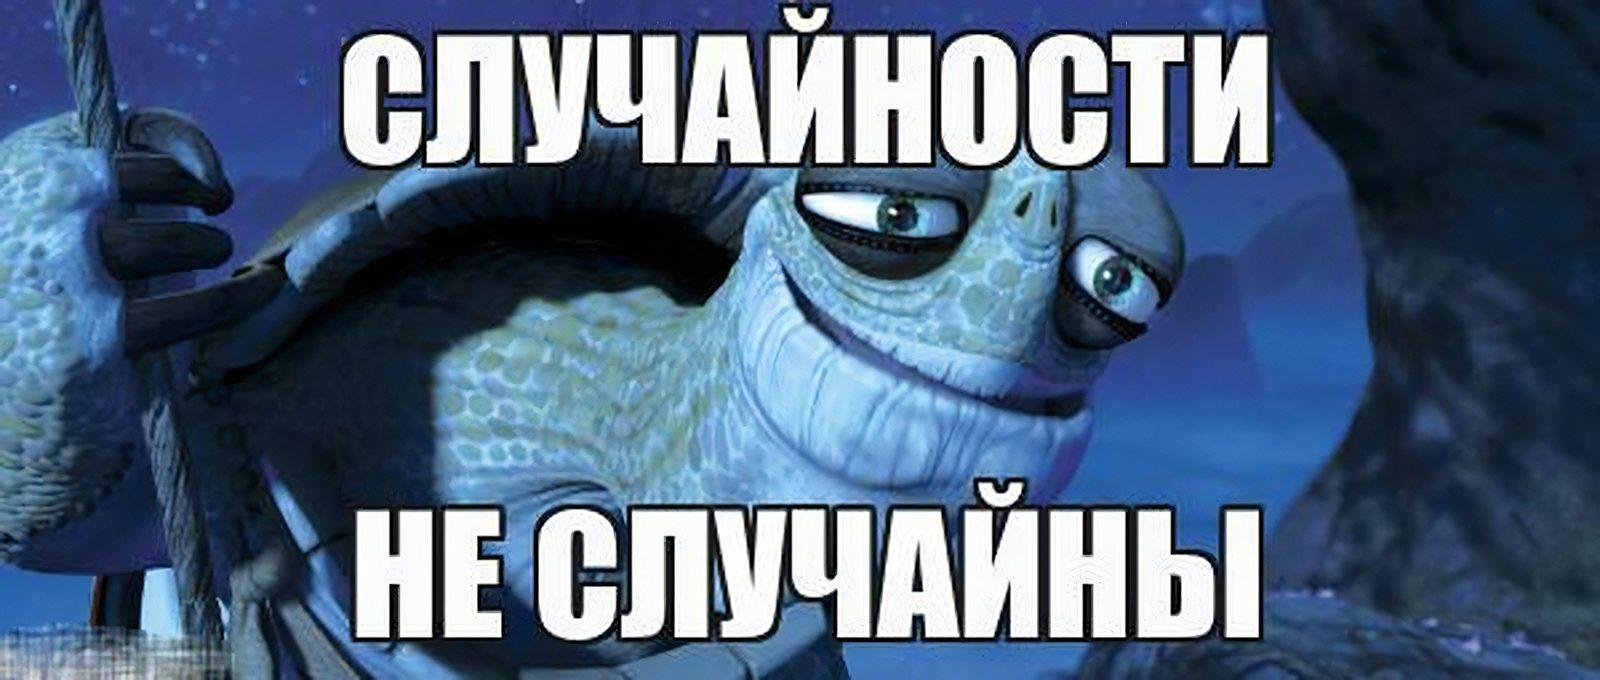

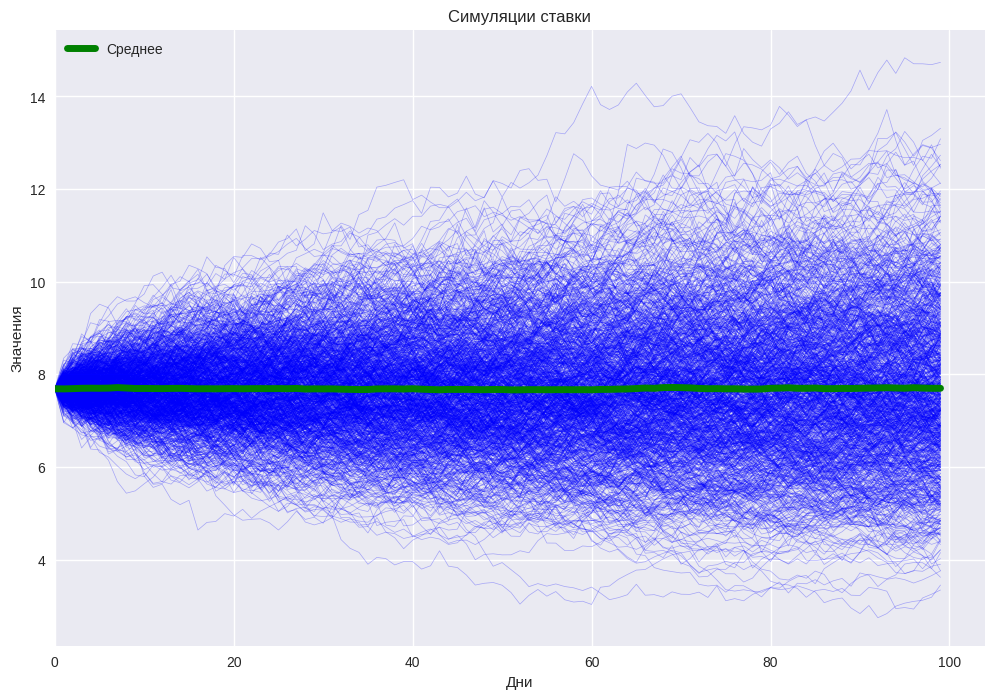

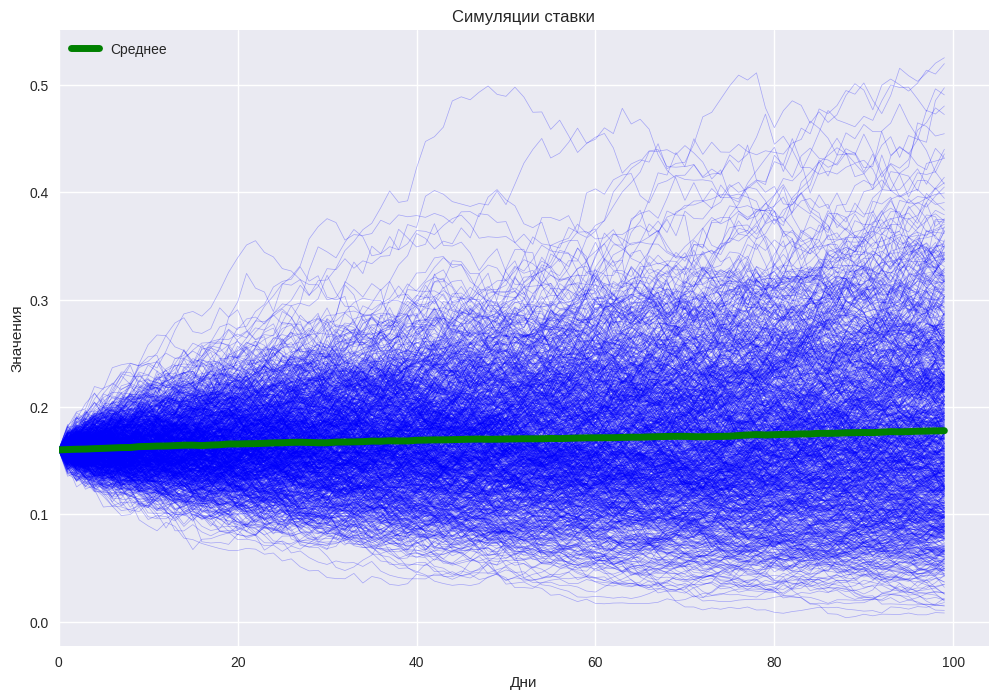

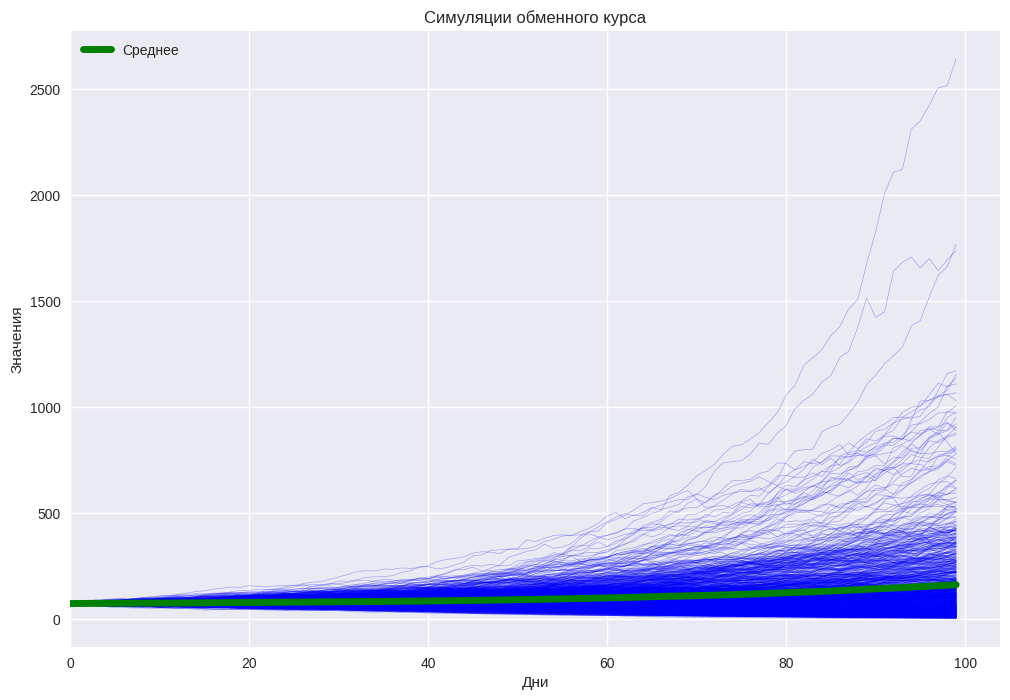

In [ ]:
dW_correlated = generate_correlated_dW(100, 1000, corr_matrix)

R_rub = generate_CIR_process(100, values_10_12_2021['rub'], a_rub, b_rub, sigma_rub, 1000, dW_correlated[0], plot=True)
R_usd = generate_CIR_process(100, values_10_12_2021['usd'], a_usd, b_usd, sigma_usd, 1000, dW_correlated[1], plot=True)
R_fx = generate_FX_process(values_10_12_2021['fx'], lambda_fx, sigma_fx, R_usd, R_rub, dW_correlated[2], plot=True)

# Задание 2. Расчёт  справедливой стоимости для продукта Range Accrual

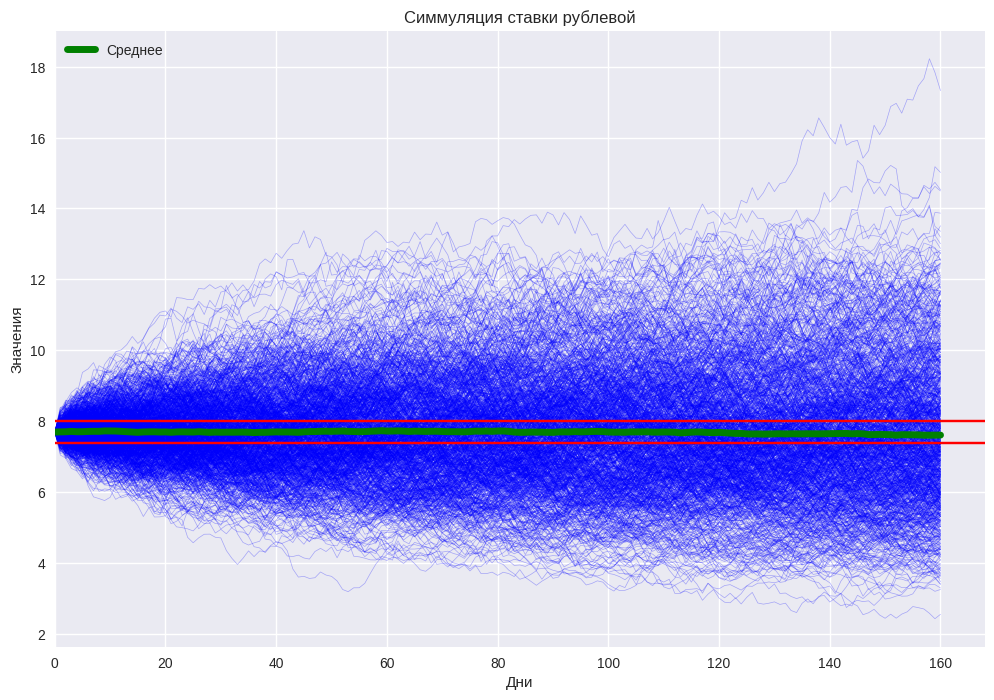

Справедливая стоимость продукта Range Accrual: 191.6273291925466


In [ ]:
import datetime
import numpy as np

def calc_fair_value(nominal, start_date, end_date,
                    cir_params, upper_bound = None, lower_bound = None,
                    sample_size=1000, plot=False):

    num_days = (end_date - start_date).days
    R_rub = generate_CIR_process(**cir_params, sample_size=sample_size)


    #оставляем только те дни, которые идут до end_date
    R_rub = R_rub[:, :num_days]

    # зададим верхнюю и нижнюю границу (в случае, если они не даны)
    upper_bound, lower_bound = set_borders(R_rub, upper_bound, lower_bound)
    if plot:
        plot_results(R_rub, title='Симмуляция ставки рублевой',
                     upper_bound=upper_bound, lower_bound=lower_bound)
    # число дней, когда не выходим за границы
    num_days_inside_borders = ((R_rub > lower_bound) & (R_rub < upper_bound)).sum(axis=1)

    # умножаем номинал на долю дней, когда выполнялось условие
    fair_prices = nominal * num_days_inside_borders / num_days
    # справедливая цена - среднее по всем траекториям
    return fair_prices.mean()

def set_borders(R_rub, upper_bound = None, lower_bound = None):
    # Если не установили, то по дефолту будем брать +- 0.3 от базового
    if upper_bound is None:
        upper_bound = R_rub[0][0] + 0.3
    if lower_bound is None:
        lower_bound = R_rub[0][0] - 0.3

    return upper_bound, lower_bound


# Пример использования
cir_params = {'N': 365, 'X_0': values_10_12_2021['rub'], 'a': a_rub, 'b': b_rub, 'sigma': sigma_rub}
product_params = {'nominal': 1000, 'start_date': datetime.date(2021, 12, 10), 'end_date': datetime.date(2022, 5, 20)}

result = calc_fair_value(**product_params, cir_params=cir_params, plot=True)
print(f"Справедливая стоимость продукта Range Accrual: {result}")

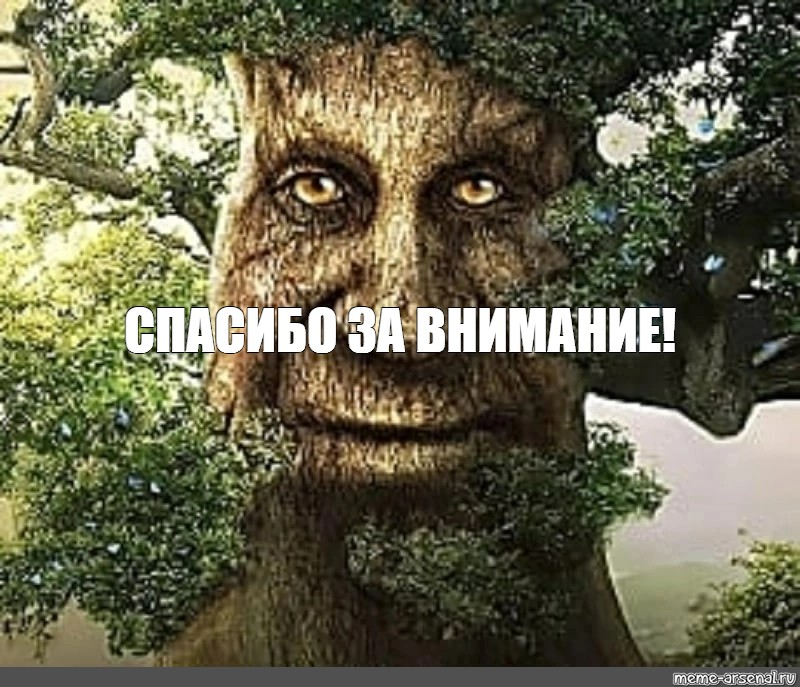